\begin{titlepage}

% Photo of FS
\centering
\vspace{-40pt}
\includegraphics[width=0.8\textwidth]{Frankfurt_School_Logo.jpg}\par
\vspace{2.5cm}

% Course
{\scshape\huge Assignment 3 \par}
\vspace{2.5cm}

% Title
{\Huge\bfseries Sparse Random Projection \par}
{\scshape\large Jan's birthday edition \par}

\vspace{2cm} % If signature is taken might have to add space.


{\Large Yannik Suhre \par}
{\Large Skyler MacGowan \par}
{\Large Debasmita Dutta \par}
{\Large Sebastian Sydow \par}
\vspace{0.5cm}

% Date
\vfill
{\large \today\par}
\end{titlepage}


\newpage

\hypersetup{linkcolor=black}
\tableofcontents

\newpage

# The Johnson-Lindenstrauss Lemma
The Johnson-Lindenstrauss (JL) Lemma is the math behind Euclidean Distance/Space; it is what proves the “*approximate maintenance of distance between the data points in different dimensions*” property to be true. The lemma states that a small set of points in a high-dimensional space can be embedded into a space of much lower dimension in such a way that distances between the points are nearly preserved. The function `johnson_lindenstrauss_min_dim` of [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.random_projection.johnson_lindenstrauss_min_dim.html)
calculates the  minimum number of components $k$, i.e. the number of dimensions in which distances between 
the points are nearly preserved, by the following formula:

\begin{equation}
k >= \frac{4 * log(n\_samples)} {(\frac{\epsilon^2}{2} - \frac{\epsilon^3}{3})}
\end{equation}

Nevertheless, this only holds if the correct $k$ dimensions are chosen and not just any $k$ dimensions.

The following outlines the key components of the JL Lemma and what they represent. 

- $k$: This represents the minimum number of dimensions to which the dataset can be reduced to without a substantive decrease in accuracy, down from the original *d* dimensions. This *k* is in effect the result obtained from the JL Lemma formula, based on the parameters provided thereto. 
- $\epsilon$: This represents the error term. Namely, in the context of conducting random projections in Euclidean space it is the **approximate** distance that is maintained, i.e. there is some error involved during this process. Naturally, that error could result in either an increase or a decrease in the distance, which is portrayed by the inequality below. In this inequality, 1 represents the original distance, $\epsilon$ represents the error the user is willing to accept (range from 0 to 1, with lower values indicating a lower tolerance for error), the superscript indicates that this inequality applies to Euclidean Space (and hence the L2 norm), the distance of the transformed vectors is portrayed by the middle term ($f(x_i) - f(x_j)$), while the outer terms represent the two possible boundaries, i.e. that the new distance is somewhat smaller or greater by $\epsilon$ than the original distance.

\begin{equation}
(1 - \epsilon) ||x_i - x_j||^2_2 \leq ||f(x_i) - f(x_j)||^2_2 \leq (1 + \epsilon) ||x_i - x_j||^2_2
\end{equation}

- $n\_samples$: This refers to the number of observations in the dataset.

**Note**: The number of dimensions is independent of the original number of features but instead depends on the size of the dataset: the larger the dataset, the higher is the minimal dimensionality of an $\epsilon$-embedding.

**Note**: In the context of dimensionality reduction, random projections are typically used when one is unable to reliably calculate the covariance matrix (due to data sparsity for example), whereas when the covariance can be reliably calculated then **P**rincipal **C**omponent **A**nalysis (PCA) is used. Both PCA and random projections require the dataset to be in Euclidean Space in order to function properly (more on Euclidean Space below). PCA is computionally more expensive which also factors into the choice of dimensionalty reduction method selected.

# Euclidean Space/Data

When a given dataset is said to be in "Euclidean Space", that means that the distance between the observations in the dataset is linearly defined. Essentially, you can draw a line between each vector pair, and this line represents the distance between each pair. Distance, in turn, is a measure of similarity, with lesser distances indicating greater similarity and vice versa. 

How is one to know whether a given dataset is in Euclidean Space? Well essentially anything embedded in physical space could reliaby said to be in Euclidean Space, because in such circumstances one can draw a line between two points and trust that that accurately represents the distance or similarity between them. In a geographical context for example, the distance *as the crow flies* between the Frankfurt School to the Abdeen Palace Museum in Cairo is 2,922.37 km whereas that between the Frankfurt School and the Church of the Holy Sepulchre in Jerusalem is 2,993.46 km; these are examples of euclidean distances, and from them we can determine that Frankfurt School is 71.12 km closer to the Abdeen Palace Museum than it is to the Church of the Holy Sepulchre. 

# Non-Euclidean Spaces/Data

In Non-Euclidean Space, the "linearity" property described above in reference to Euclidean space does not hold; one cannot simply draw a line between the constituent vector pairs and trust that this is an accurate measure of the similarity thereof (it isn't). Instead, in non-euclidean spaces the degree of similarity of the vectors should be measured using another (non-linear) scale, e.g. logarithmic, exponential, etc. 

For example, we define the loudness of a given sound via the decibel (dB) measure. In this measure, an increase of three decibels corresponds to a doubling of the overall loudness. Another fairly well-known example would be the moment-magnitude scale, which is the principal measure now used when assessing the strength and destructive potential of earthquakes. This scale goes from one to ten, with each step representing a 32 times larger release of energy than the preceeding step. For example, a 8.0 earthquake ("Great", occurs roughly once a year) releases 31,623 times as much energy as does a 5.0 earthquake ("Moderate", occurs roughly 1250 times per year).

United States Geographical Survey Earthquake Magnitude Comparison Calculator: https://earthquake.usgs.gov/education/calculator.php

In [1]:
# Group 10 - Skyler MacGowan, Sebastian Sydow, Debasmita Dutta, Yannik Suhre
from sklearn.svm import LinearSVC, SVC
from RandomProjectionClass import RandomSparseRepresentation
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Introduction to the Datasets

For this assignment, two datasets from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php.) were chosen. Below is an overview of these datasets.  

## Classification of Frogs
The dataset is used to classify the species of frogs. As the dataset encompasses ten different classes, i.e. `Species`, it is a multi-class classification. The dataset contains 7,195 observations and 23 features, one of which is the target-feature (`Species`, after deleting the columns `Family`, `Genus` and `RecordID`). It is an imbalanced dataset, as some classes are much more frequent than others. Thus, the performance of the classifier will be evaluated using the `f1_score` with the parameter settings `average = weighted`. This dataset is already standardized.  

Data Source: https://archive.ics.uci.edu/ml/datasets/Anuran+Calls+%28MFCCs%29

## Classification of Dry Beans  
The dataset is used to classify dry beans into seven different classes; it is a multi-class classification. The dataset contains 13,611 observations and 17 features, one of which is the target-feature (`Class`).As with the first dataset, the performance of the classifier will be evaluated using the `f1_score` with the parameter settings `average = weighted` as this dataset is also imbalanced. This dataset is not yet standardized.

Data Source: https://archive.ics.uci.edu/ml/datasets/Dry+Bean+Dataset

In [11]:
data = RandomSparseRepresentation(birthday_version=False)


# Welcome to the interface of **RandomSparseRepresentation**!
        
You have now instantiated an object, with which you can create a RandomSparseRepresentation.
The function ```get_data()``` retrieves the data, which was previously downloaded from the sources outlined above.

In [12]:
data.get_data("./data/Frogs_MFCCs.csv",
              data_type = ".csv")

You successfully loaded your dataset to the object!

Now we can go ahead and split the data.
Please call the `split_data()` function for it. You can pass it the `test_size` parameter, to split your
data into test and train sets, the default value is `0.3`. Here are the first 5 rows of our data:

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,...,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,Family,Genus,Species,RecordID
0,1.0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,...,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038,Leptodactylidae,Adenomera,AdenomeraAndre,1
1,1.0,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,...,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056,Leptodactylidae,Adenomera,AdenomeraAndre,1
2,1.0,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,...,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162,Leptodactylidae,Adenomera,AdenomeraAndre,1
3,1.0,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,...,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954,Leptodactylidae,Adenomera,AdenomeraAndre,1
4,1.0,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,...,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244,Leptodactylidae,Adenomera,AdenomeraAndre,1


In [13]:
data.split_data(standardize = False, columns_to_drop = ["RecordID", "Family", "Genus"])

The first thing we need to do, is to determine which of the columns shall be our target variable.
Hence they are all printed out in the next step.

['MFCCs_ 1', 'MFCCs_ 2', 'MFCCs_ 3', 'MFCCs_ 4', 'MFCCs_ 5', 'MFCCs_ 6', 'MFCCs_ 7', 'MFCCs_ 8', 'MFCCs_ 9', 'MFCCs_10', 'MFCCs_11', 'MFCCs_12', 'MFCCs_13', 'MFCCs_14', 'MFCCs_15', 'MFCCs_16', 'MFCCs_17', 'MFCCs_18', 'MFCCs_19', 'MFCCs_20', 'MFCCs_21', 'MFCCs_22', 'Family', 'Genus', 'Species', 'RecordID']

In the next step please input a column name, which contains your target variable.

Please input your target variable here: Species


Your data has now be split into a train and test set by a factor of `0.3`.
This was done by selecting the column `Species` as the target column and the rest as independent variables.

In [14]:
data.JL_lemma()

In general, the theory of Professor Johnson and Professor Lindenstrauss posits
the amount of columns to which we can reduce our dataset without losing any distance related information.
We can specify a parameter called `epsilon` which determines the margin in which the distance is contained.

Our current dataset has 7195 observations and 26 dimensions. Using the JL algorithm $k$ = 
7612 dimensions.

Nevertheless, dimensionality reduction can still work with lower dimensions.

The next step is to set a baseline metric, which can be used to evaluate the algorithm with
the reduced dataset. For this please call the function `baseline()`.

In [6]:
data.baseline(model = SVC, kernel='rbf', gamma = 0.1, C=5, random_state = 0)

In order to assess the performance of a classifier, it is important to incorporate a numerical evaluation of the algorithm. 
For this, a variety of performance measures are available. It is essential to make use of an adequate performance measure as 
their applicability and significance depend on the dataset as well as the specific classification task.
There are a few metrics we can choose from, the needed API (which you need to input next) can be viewed
[here](https://scikit-learn.org/stable/modules/model_evaluation.html). For the task at hand, the performance 
measures used are either *accuracy* or the $f_1$ *score*.

\begin{equation}
Accuracy = \frac{True\ Positives + True\ Negatives }{True\ Positives + False\ Positives + True\ Negatives + False\ Negatives}
\end{equation}

*Accuracy* measures the performance of a classification model as the number of correct 
predictions divided by the total number of predictions. Its main advantage is its easy interpretability. 
Nevertheless, *accuracy* should only be used for balanced datasets. When dealing with imbalanced datasets,
i.e. when some classes are much more frequent than others, *accuracy* is not a reliable performance measure. 

\begin{equation}
f_1 = 2 * \frac{Precision * Recall}{Precision + Recall}
\end{equation}

The $f_1$ Score is the harmonic mean of *precision* and *recall*, i.e. it applys equal weight to both. 
The $f_1$ Score represents a meaningful evaluation for imbalanced datasets. As such, we recommend to
choose `accuracy_score` for balanced datasets and `f1_score` for imbalanced datasets.

Additionally, for imbalanced datasets, i.e. situations in which the `f1_score` is chosen, the user should differentiate
between binary and multi-class classification. For multi-class classification, the 
parameter *average* ought to be specified, as its default is only applicable if targets are
[binary](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score).
Four other parameter values are possible: *micro*, *macro*, *weighted* and *samples*. *Samples* is only 
meaningful for multilabel classification, which will not be in the scope of this assignment. Thus, we will 
only examine *micro*, *macro* and *weighted*. 

The *macro* $f_1$ *score* is computed as a simple arithmetic mean of the per-class $f_1$ *scores*. 
It does not take label imbalance into account.

The *weighted* $f_1$ *score* alters *macro* to account for label imbalance. The weight is applied by 
the number of true instances for each label.

The *micro* $f_1$ *score* is calculated counting the total true positives, false negatives and false positives.
Thus, the *micro* $f_1$ *score* is equal to total number of true positives over the total number of all observations.
Further explanations can be found
[here](https://scikit-learn.org/stable/modules/model_evaluation.html#multiclass-and-multilabel-classification.).

In conclusion, we recommend to chose `average = weighted` for the performance metric `f1_score` for the 
purpose of this assignment as this will account for the imbalance in the dataset. 

The chosen metric used for our baseline should be inputted in the following prompt. Be sure to insert it 
like `accuracy_score` if you want to use `accuracy_score` or respective for all other metrics.

Please insert your metric here: f1_score="average"


You have chosen a metric which is not available here. Please see this
                list for further info, please input the metric exactly like depicted here:
                `accuracy_score`,`balanced_accuracy_score`, `top_k_accuracy_score`, `average_precision_score`,
                `brier_score_loss`, `f1_score`,  `log_loss`, `precision_score`, `recall_score`, `jaccard_score`,
                `roc_auc_score`.

Please insert your metric here: f1_score


You have selected the `f1_score`. Since the `f1_score` can have different
                usages as described earlier, depending on its inputs please input some keyword-arguments into
                the next prompt.
                Please be advised, that this is done via `average="weighted", ...`, meaning with a = as separator.

Please enter your keyword arguments here: average="weighted"


Awesome, you have set your baseline! Now call the function `apply_random_projection` to check out,
    how good your model performs when we reduce its dimensions.

In [7]:
data.apply_random_projection(model = SVC, kernel='rbf', gamma = 0.1, C=5, random_state = 0)


Random Projection is a dimensionality reduction technique which is based on the **Johnson-Lindenstrauss lemma**.
This method projects or transforms the higher dimensional data to a lower dimensional subspace.
It approximately preserves the pairwise distances of the data points. 
It uses a random matrix to perform the projection and hence the name random projection. 
This matrix is also sometimes refered to as map.

If the original dimension of data is $d$ and the target or projected dimension is $k$, where $k<<d$ 
then the random matrix is of size $k,\ d$. The random projection is explained below.

\begin{equation}
X_{k,\ N}^{RP} = R_{k,\ d} X_{d,\ N}
\end{equation}

Where

$X_{k,\ N}^{RP}$ is the random projected N observations in $k$ dimensions,

$R_{k,\ d}$ is the random matrix used for the projection or transformation,

$X_{d,\ N}$ is the original $N$ observations in d-dimension.

There are a few techniques to create the random matrix. Gaussian and Sparse are just 2 among them.

**Gaussian** – The random matrix is created in such a way that each entry is independently drawn from
the standard normal distribution $N(0, \frac{1}{n_{components}})$. Where $n_{components}$ is the dimensionality
of the target projection space.

**Sparse** – When a sparse matrix is used for the random projection to reduce the computational complexity, then this 
is a sparse projection. This is an alternate approach to Gaussian random projection matrix which ensures that a similar distance
between the observations is preserved while reducing the dimensions.

If the sparse projection matrix has $c$ nonzero entries per column, then the complexity of the operation 
is of order $O(ckN)$ instead of $O(dkN)$.

Now we can perform the same actions for our second dataset.

In [15]:
dry_beans = RandomSparseRepresentation(text = False)

In [16]:
# Plot explained variances
dry_beans.prepare_fit(url = "./data/Dry_Bean_Dataset.xlsx", data_type = ".xlsx",
                     standardize = True,
                     model = SVC, kernel='rbf', gamma = 0.1, C=5, random_state = 0)

The columns of this dataset are: ['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent', 'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2', 'ShapeFactor3', 'ShapeFactor4', 'Class']

Please input your target variable here: Class
Please insert your metric here: accuracy


You have chosen a metric which is not available here. Please see this
                list for further info, please input the metric exactly like depicted here:
                `accuracy_score`,`balanced_accuracy_score`, `top_k_accuracy_score`, `average_precision_score`,
                `brier_score_loss`, `f1_score`,  `log_loss`, `precision_score`, `recall_score`, `jaccard_score`,
                `roc_auc_score`.

Please insert your metric here: accuracy_score


AttributeError: 'RandomSparseRepresentation' object has no attribute 'kwargs'

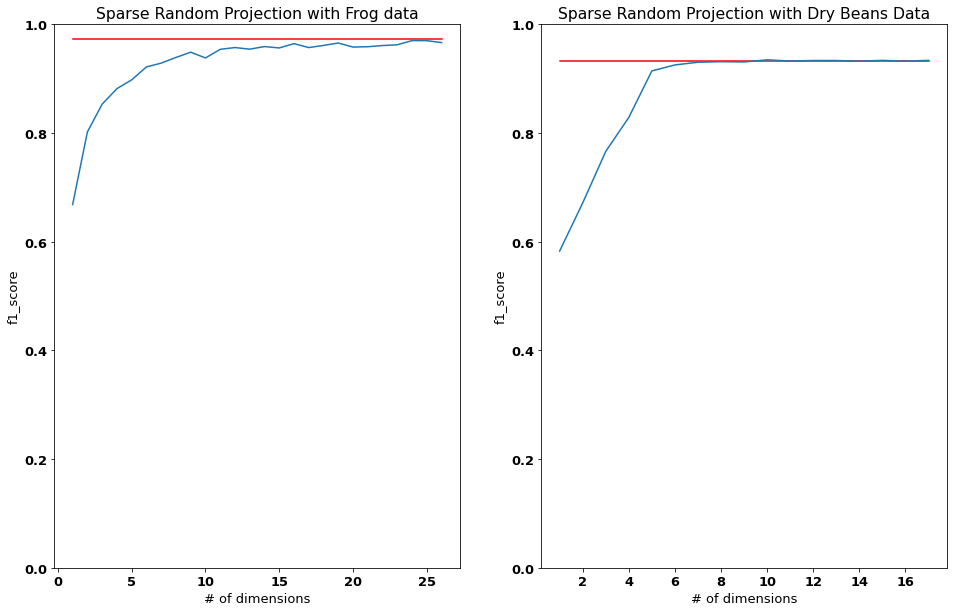

In [10]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 13}

plt.rc('font', **font)

fig, ax = plt.subplots(1,2, figsize = (16,10))
ax[0].set_ylim([0,1])
ax[0].plot(data.dims, [data.baseline] * len(data.accuracies), color = "r")
ax[0].plot(data.dims, data.accuracies)
ax[0].set_title("Sparse Random Projection with Frog data")
ax[0].set_xlabel('# of dimensions')
ax[0].set_ylabel(f"{data.metric}")
ax[1].plot(dry_beans.dims, [dry_beans.baseline] * len(dry_beans.accuracies), color = "r")
ax[1].plot(dry_beans.dims, dry_beans.accuracies)
ax[1].set_title("Sparse Random Projection with Dry Beans Data")
ax[1].set_ylim([0,1])
ax[1].set_xlabel('# of dimensions')
ax[1].set_ylabel(f"{dry_beans.metric}")
plt.show() 

# Takeaway to go
As can be inferred from both graphs above, the random dimensionality reduction worked for both datasets, even for smaller dimensions than those obtained from the JL Lemma. In both cases, we see how initially the performance following a reduction in dimensionality stays at or just slightly below the baseline. At a certain point however, the new performance drops off substantially, again in both datasets. This point (where the new performance decreases substantially), represents the number of dimensions that should be maintained when conducting the dimensionality reductions. Furthermore, both classifiers perform very well as can be seen by the high `f1_score`s.
